# Data analysis + model selection

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import json
sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 150

# sklearn part
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

In [23]:
df = pd.read_csv("../data/churn.csv")

Three functions called at the beginning of analysis:

In [24]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Our goal will be to classify whether customer with given profile will leave the bank or not.
That means classification task.

In [6]:
# variable that we will try to predict
Y = df["churn"]

In [7]:
df.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

We can optimise the memory usage by appropriate column types changing.

In [25]:
df = (df
      .astype({"gender": "category", "country": "category", "products_number": "category",
               "credit_card": bool, "active_member": bool, "churn": bool})
      .drop(["customer_id"], axis=1)
)
df

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,True,True,101348.88,True
1,608,Spain,Female,41,1,83807.86,1,False,True,112542.58,False
2,502,France,Female,42,8,159660.80,3,True,False,113931.57,True
3,699,France,Female,39,1,0.00,2,False,False,93826.63,False
4,850,Spain,Female,43,2,125510.82,1,True,True,79084.10,False
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,True,False,96270.64,False
9996,516,France,Male,35,10,57369.61,1,True,True,101699.77,False
9997,709,France,Female,36,7,0.00,1,False,True,42085.58,True
9998,772,Germany,Male,42,3,75075.31,2,True,False,92888.52,True


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   credit_score      10000 non-null  int64   
 1   country           10000 non-null  category
 2   gender            10000 non-null  category
 3   age               10000 non-null  int64   
 4   tenure            10000 non-null  int64   
 5   balance           10000 non-null  float64 
 6   products_number   10000 non-null  category
 7   credit_card       10000 non-null  bool    
 8   active_member     10000 non-null  bool    
 9   estimated_salary  10000 non-null  float64 
 10  churn             10000 non-null  bool    
dtypes: bool(3), category(3), float64(2), int64(3)
memory usage: 449.8 KB


In [10]:
categories = ["country", "gender", "products_number", "credit_card", "active_member", "churn"]

## EDA 

**Warning:** the explanatory data analysis presented below cannot be regarded as extensive. Much more deeper look into data is required.

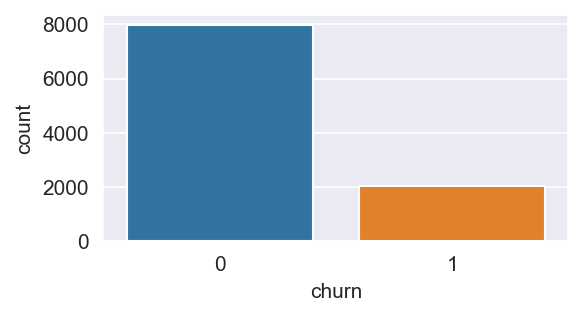

In [15]:
fig, ax = plt.subplots(figsize=(4, 2))
sns.countplot(data=df, x="churn")
plt.show()
# not balanced

<AxesSubplot:xlabel='balance', ylabel='estimated_salary'>

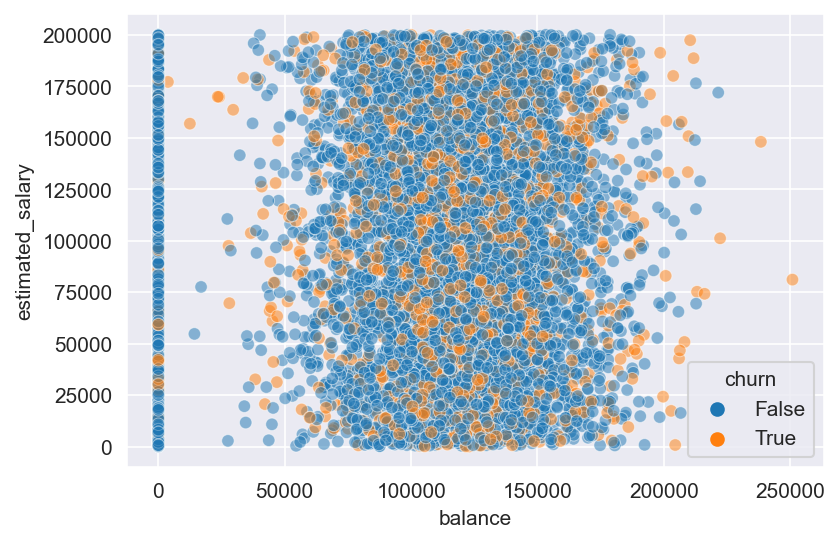

In [31]:
sns.scatterplot(data=df, x="balance", y="estimated_salary", alpha=0.5, hue="churn")

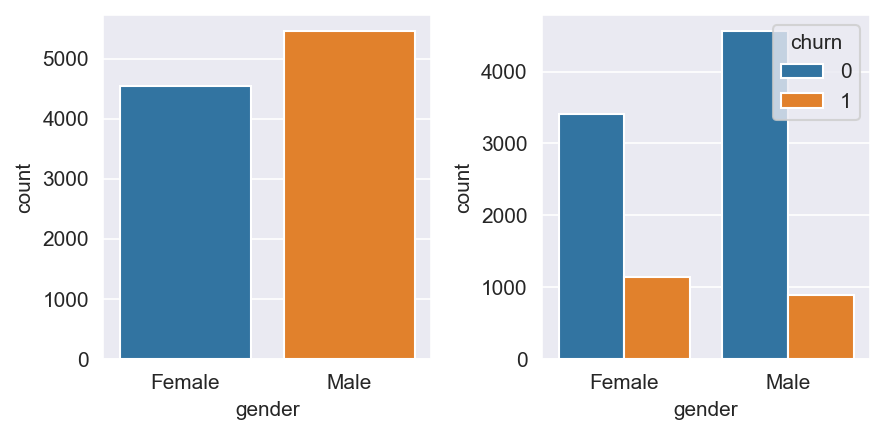

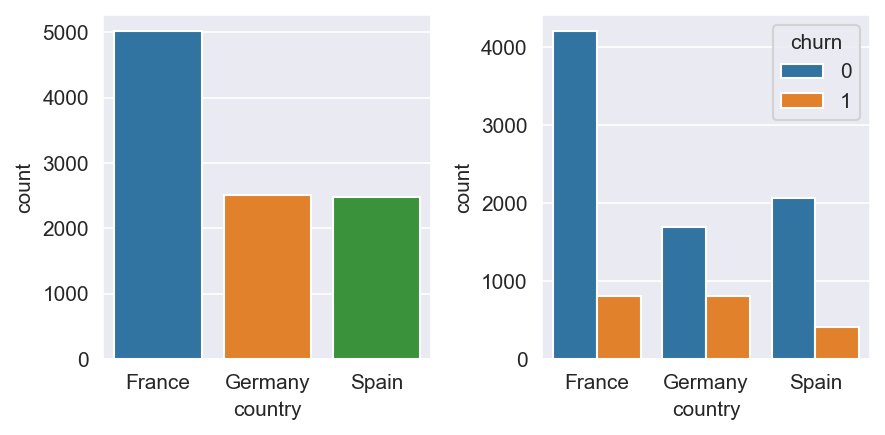

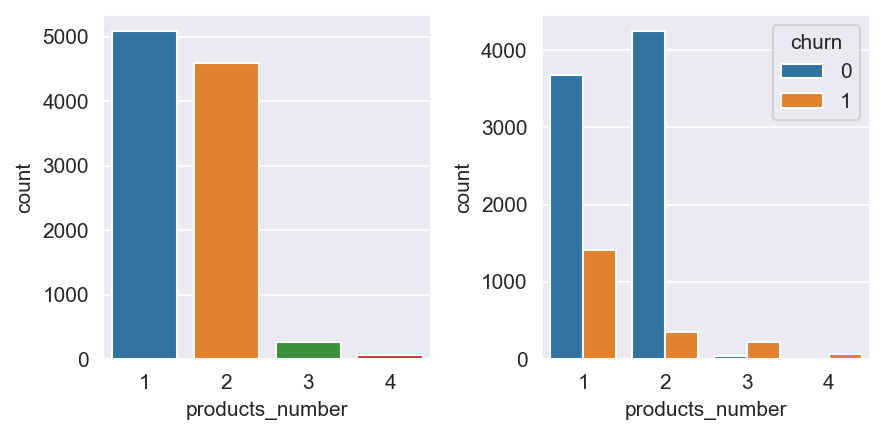

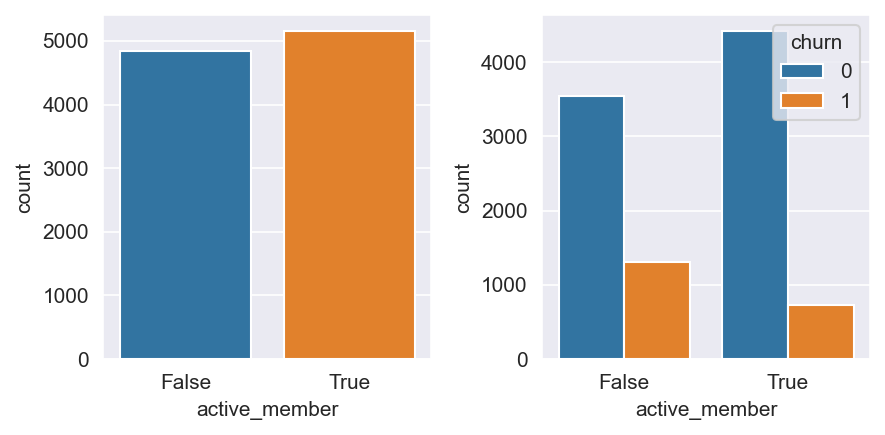

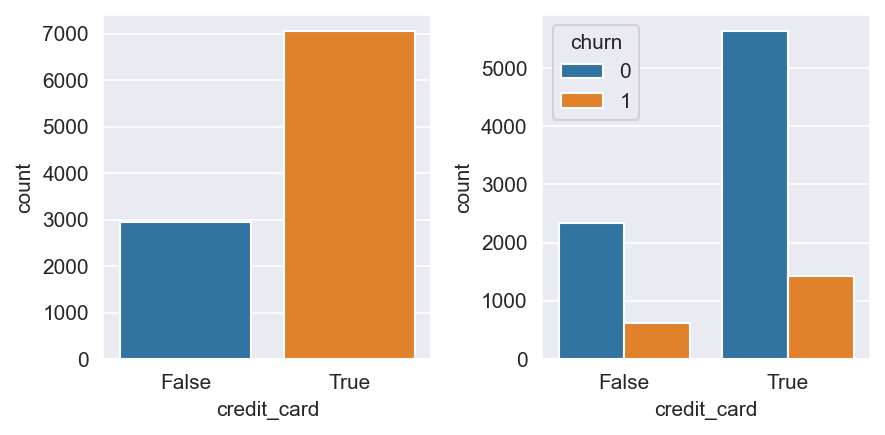

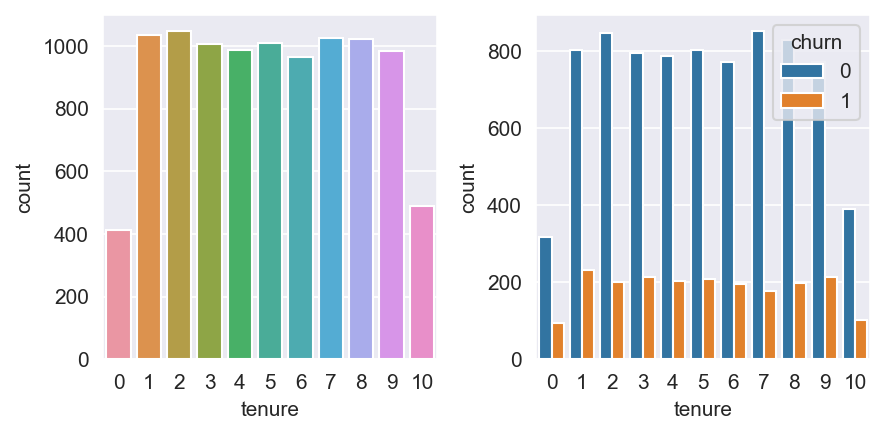

In [16]:
for column in ["gender", "country", "products_number", "active_member", "credit_card", "tenure"]:
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    sns.countplot(data=df, x=column, ax=ax[0])
    sns.countplot(data=df, x=column, hue="churn", ax=ax[1])
    plt.tight_layout()
    plt.show()

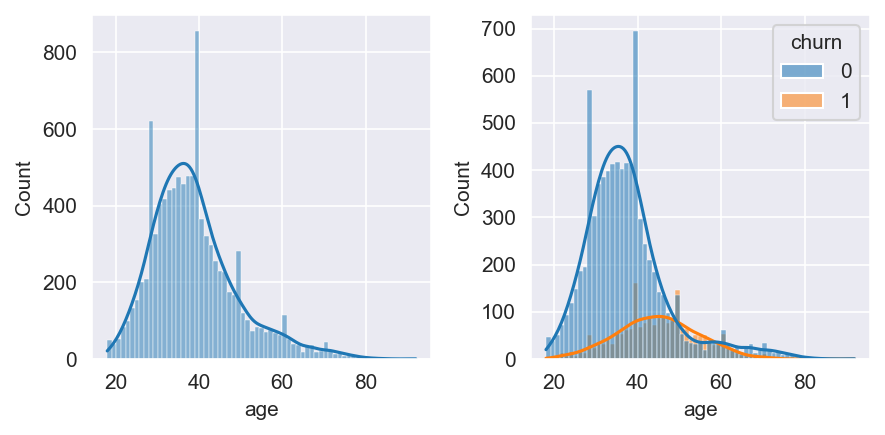

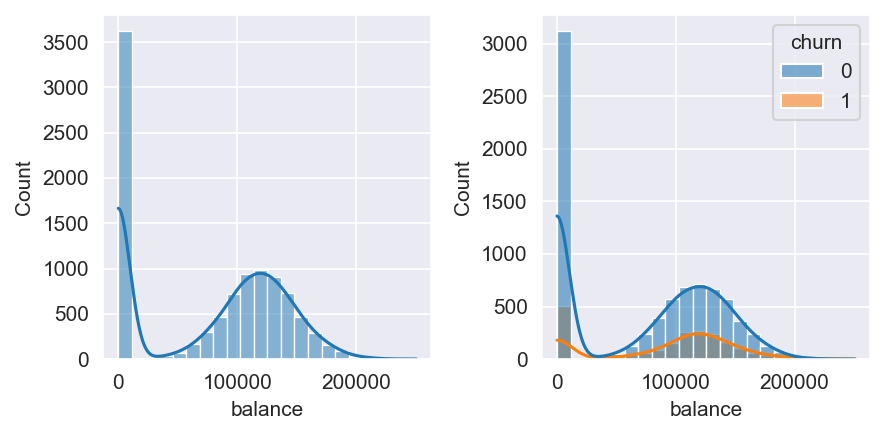

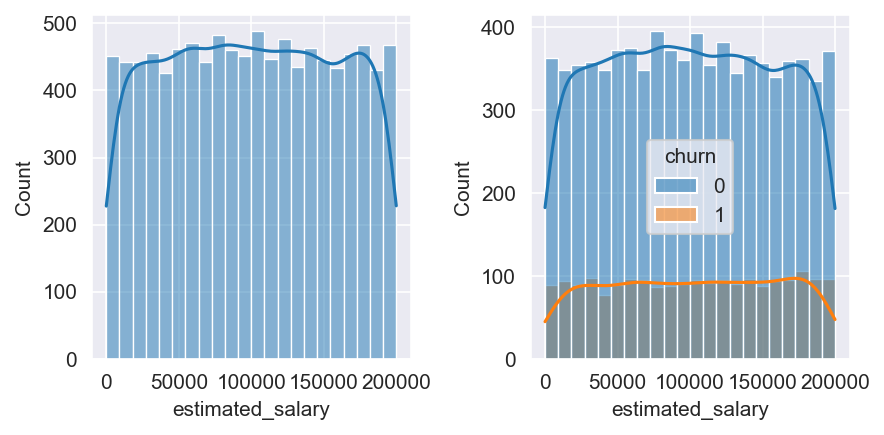

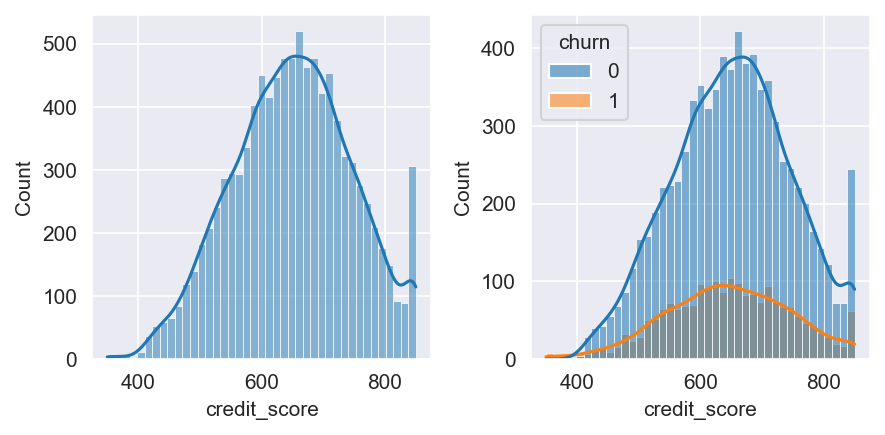

In [17]:
for column in ["age", "balance", "estimated_salary", "credit_score"]:
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    sns.histplot(data=df, x=column, kde=True, ax=ax[0])
    sns.histplot(data=df, x=column, hue="churn", kde=True, alpha=0.55, ax=ax[1])
    plt.tight_layout()
    plt.show()

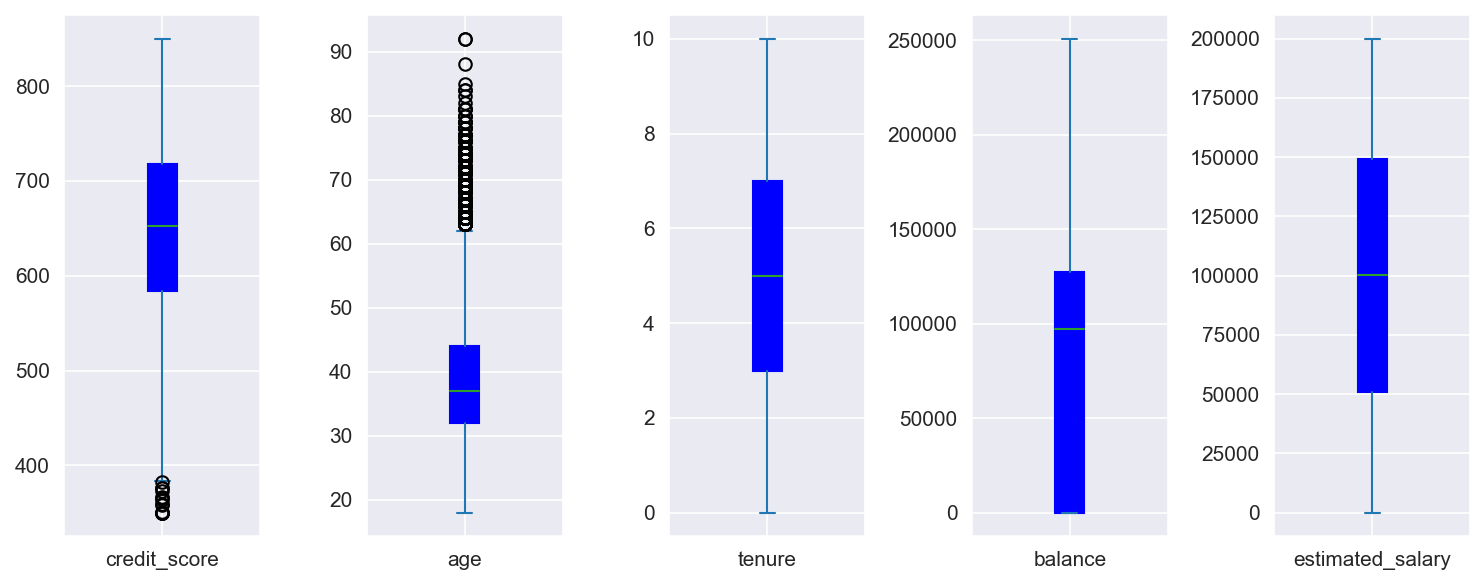

In [18]:
df.plot(kind='box', subplots=True, sharey=False, figsize=(10, 4), color=dict(boxes="Blue"), patch_artist=True)
plt.tight_layout()
plt.show()


<AxesSubplot:>

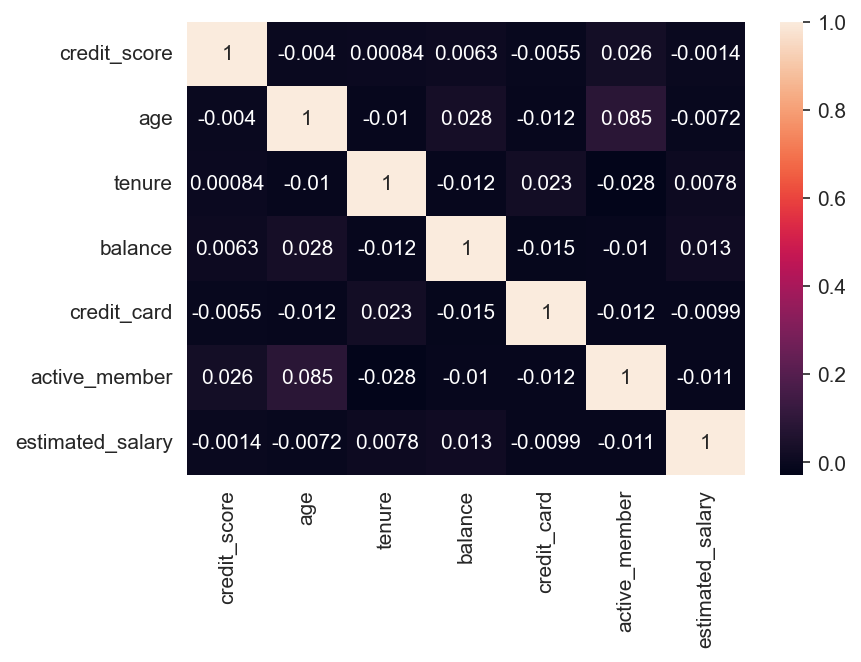

In [19]:
sns.heatmap(df.corr(), annot=True)

In [21]:
def quantile(p):
    def quantile_(x):
        return x.quantile(p)
    quantile_.__name__ = f'quantile({p})'
    return quantile_


(df.groupby(by="churn")[[column for column in df.columns if column not in categories]].
 agg([np.mean, np.var, np.std, quantile(0.25), quantile(0.5), quantile(0.75)]).T
)

churn                                       0             1
credit_score     mean            6.518532e+02  6.453515e+02
                 var             9.149657e+03  1.006440e+04
                 std             9.565384e+01  1.003215e+02
                 quantile(0.25)  5.850000e+02  5.780000e+02
                 quantile(0.5)   6.530000e+02  6.460000e+02
                 quantile(0.75)  7.180000e+02  7.160000e+02
age              mean            3.740839e+01  4.483800e+01
                 var             1.025230e+02  9.528808e+01
                 std             1.012536e+01  9.761562e+00
                 quantile(0.25)  3.100000e+01  3.800000e+01
                 quantile(0.5)   3.600000e+01  4.500000e+01
                 quantile(0.75)  4.100000e+01  5.100000e+01
tenure           mean            5.033279e+00  4.932744e+00
                 var             8.298189e+00  8.620720e+00
                 std             2.880658e+00  2.936106e+00
                 quantile(0.25)  3.000000e+00  2.000000e+00
                 quantile(0.5)   5.000000e+00  5.000000e+00
                 quantile(0.75)  7.000000e+00  8.000000e+00
balance          mean            7.274530e+04  9.110854e+04
                 var             3.949876e+09  3.405982e+09
                 std             6.284804e+04  5.836079e+04
                 quantile(0.25)  0.000000e+00  3.834002e+04
                 quantile(0.5)   9.207268e+04  1.093493e+05
                 quantile(0.75)  1.264103e+05  1.314333e+05
estimated_salary mean            9.973839e+04  1.014657e+05
                 var             3.295401e+09  3.353848e+09
                 std             5.740559e+04  5.791242e+04
                 quantile(0.25)  5.078349e+04  5.190772e+04
                 quantile(0.5)   9.964504e+04  1.024608e+05
                 quantile(0.75)  1.486100e+05  1.524229e+05

## Machine learning part

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   credit_score      10000 non-null  int64   
 1   country           10000 non-null  category
 2   gender            10000 non-null  category
 3   age               10000 non-null  int64   
 4   tenure            10000 non-null  int64   
 5   balance           10000 non-null  float64 
 6   products_number   10000 non-null  category
 7   credit_card       10000 non-null  bool    
 8   active_member     10000 non-null  bool    
 9   estimated_salary  10000 non-null  float64 
 10  churn             10000 non-null  bool    
dtypes: bool(3), category(3), float64(2), int64(3)
memory usage: 449.8 KB


In [33]:
df_ = df.drop("churn", axis=1)

In [34]:
numerical = list(filter(lambda x: df_[x].dtype in [np.int64, np.float64], df_.columns))

In [35]:
categorical = list(filter(lambda x: x not in numerical, df_.columns))

In [36]:
# column transformer
column_transformer = make_column_transformer(
    (StandardScaler(), numerical),
    (OneHotEncoder(drop="first"), categorical)
)

In [37]:
data = column_transformer.fit_transform(df_)

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

In [42]:
clfs = [AdaBoostClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(),
        RandomForestClassifier(), GaussianNB(), SVC()]

clfs_names = ["AdaBoost", "KNeighbours", "DecisionTree", "RandomForest", "GaussianNB", "SVC"]

In [50]:
results = pd.DataFrame()

for (clf_name, clf) in zip(clfs_names, clfs):
    clf.fit(X_train, Y_train)
    predictions = clf.predict(X_test)
    accuracy_score_ = accuracy_score(Y_test, predictions)
    f1_score_ = f1_score(Y_test, predictions)
    results[clf_name] = [accuracy_score_, f1_score_]

In [60]:
results.T.rename({0: "accuracy", 1: "f1-score"}, axis=1).sort_values(by=["accuracy", "f1-score"], ascending=False)

,accuracy,f1-score
RandomForest,0.8660,0.585139
SVC,0.8605,0.521441
AdaBoost,0.8570,0.573134
KNeighbours,0.8365,0.481775
GaussianNB,0.8235,0.234273
DecisionTree,0.7830,0.485782


Was this choice good? Did it have a good reasoning?

In [84]:
# hypereparameters tuning
n_estimators = [int(x) for x in np.arange(50, 1000, 50)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestClassifier()

rf_random = GridSearchCV(estimator=rf, param_grid=random_grid, 
                         cv=3, n_jobs=-1)

rf_random.fit(X_train, Y_train)

In [ ]:
best_params = rf_random.best_params_
with open("../model/best_params.json", "w") as file:
    json.dump(best_params, file)

with open("../model/best_params.json", "r") as file: best_params = json.load(file)
rf = RandomForestClassifier(**best_params)